 #### Import Libraries and Load Dataset

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# Load the dataset
file_path = '42_augmented_synonym_clean.csv'#'cleaned_dataset_49_update_real_augment.csv'
df = pd.read_csv(file_path)
df.head()

,Title,Description
0,Receptionist,AMERIA Closed Joint Stock Company seeking Rece...
1,Receptionist,VTnova LLC invite application highly qualified...
2,Lawyer,UMCOR United Methodist Committee Relief Armeni...
3,Lawyer,ACRA Credit Bureau announcing open position at...
4,Cook,Committed person fulfil position Chief Cook


In [2]:
df['Title'].value_counts()

Title
Data Analyst                    685
Marketing                       566
Cook                            511
Lawyer                          497
Financial services              483
Technicians                     477
Customer support - Sales        468
Civil Engineer                  461
Landscaping - workers           456
Logistics                       449
Human resources                 445
Web Developer                   443
Retail services                 441
Other Developer                 437
Java Developer                  427
Frontend Developer              421
Software Engineer               414
Teachers                        413
Pharmacist                      412
Business Analyst                409
Hotel Manager                   404
Receptionist                    403
Sales Executive                 402
Barman                          400
Restaurant Manager              394
Systems Engineer                392
Chambermaid                     387
Application Developer 

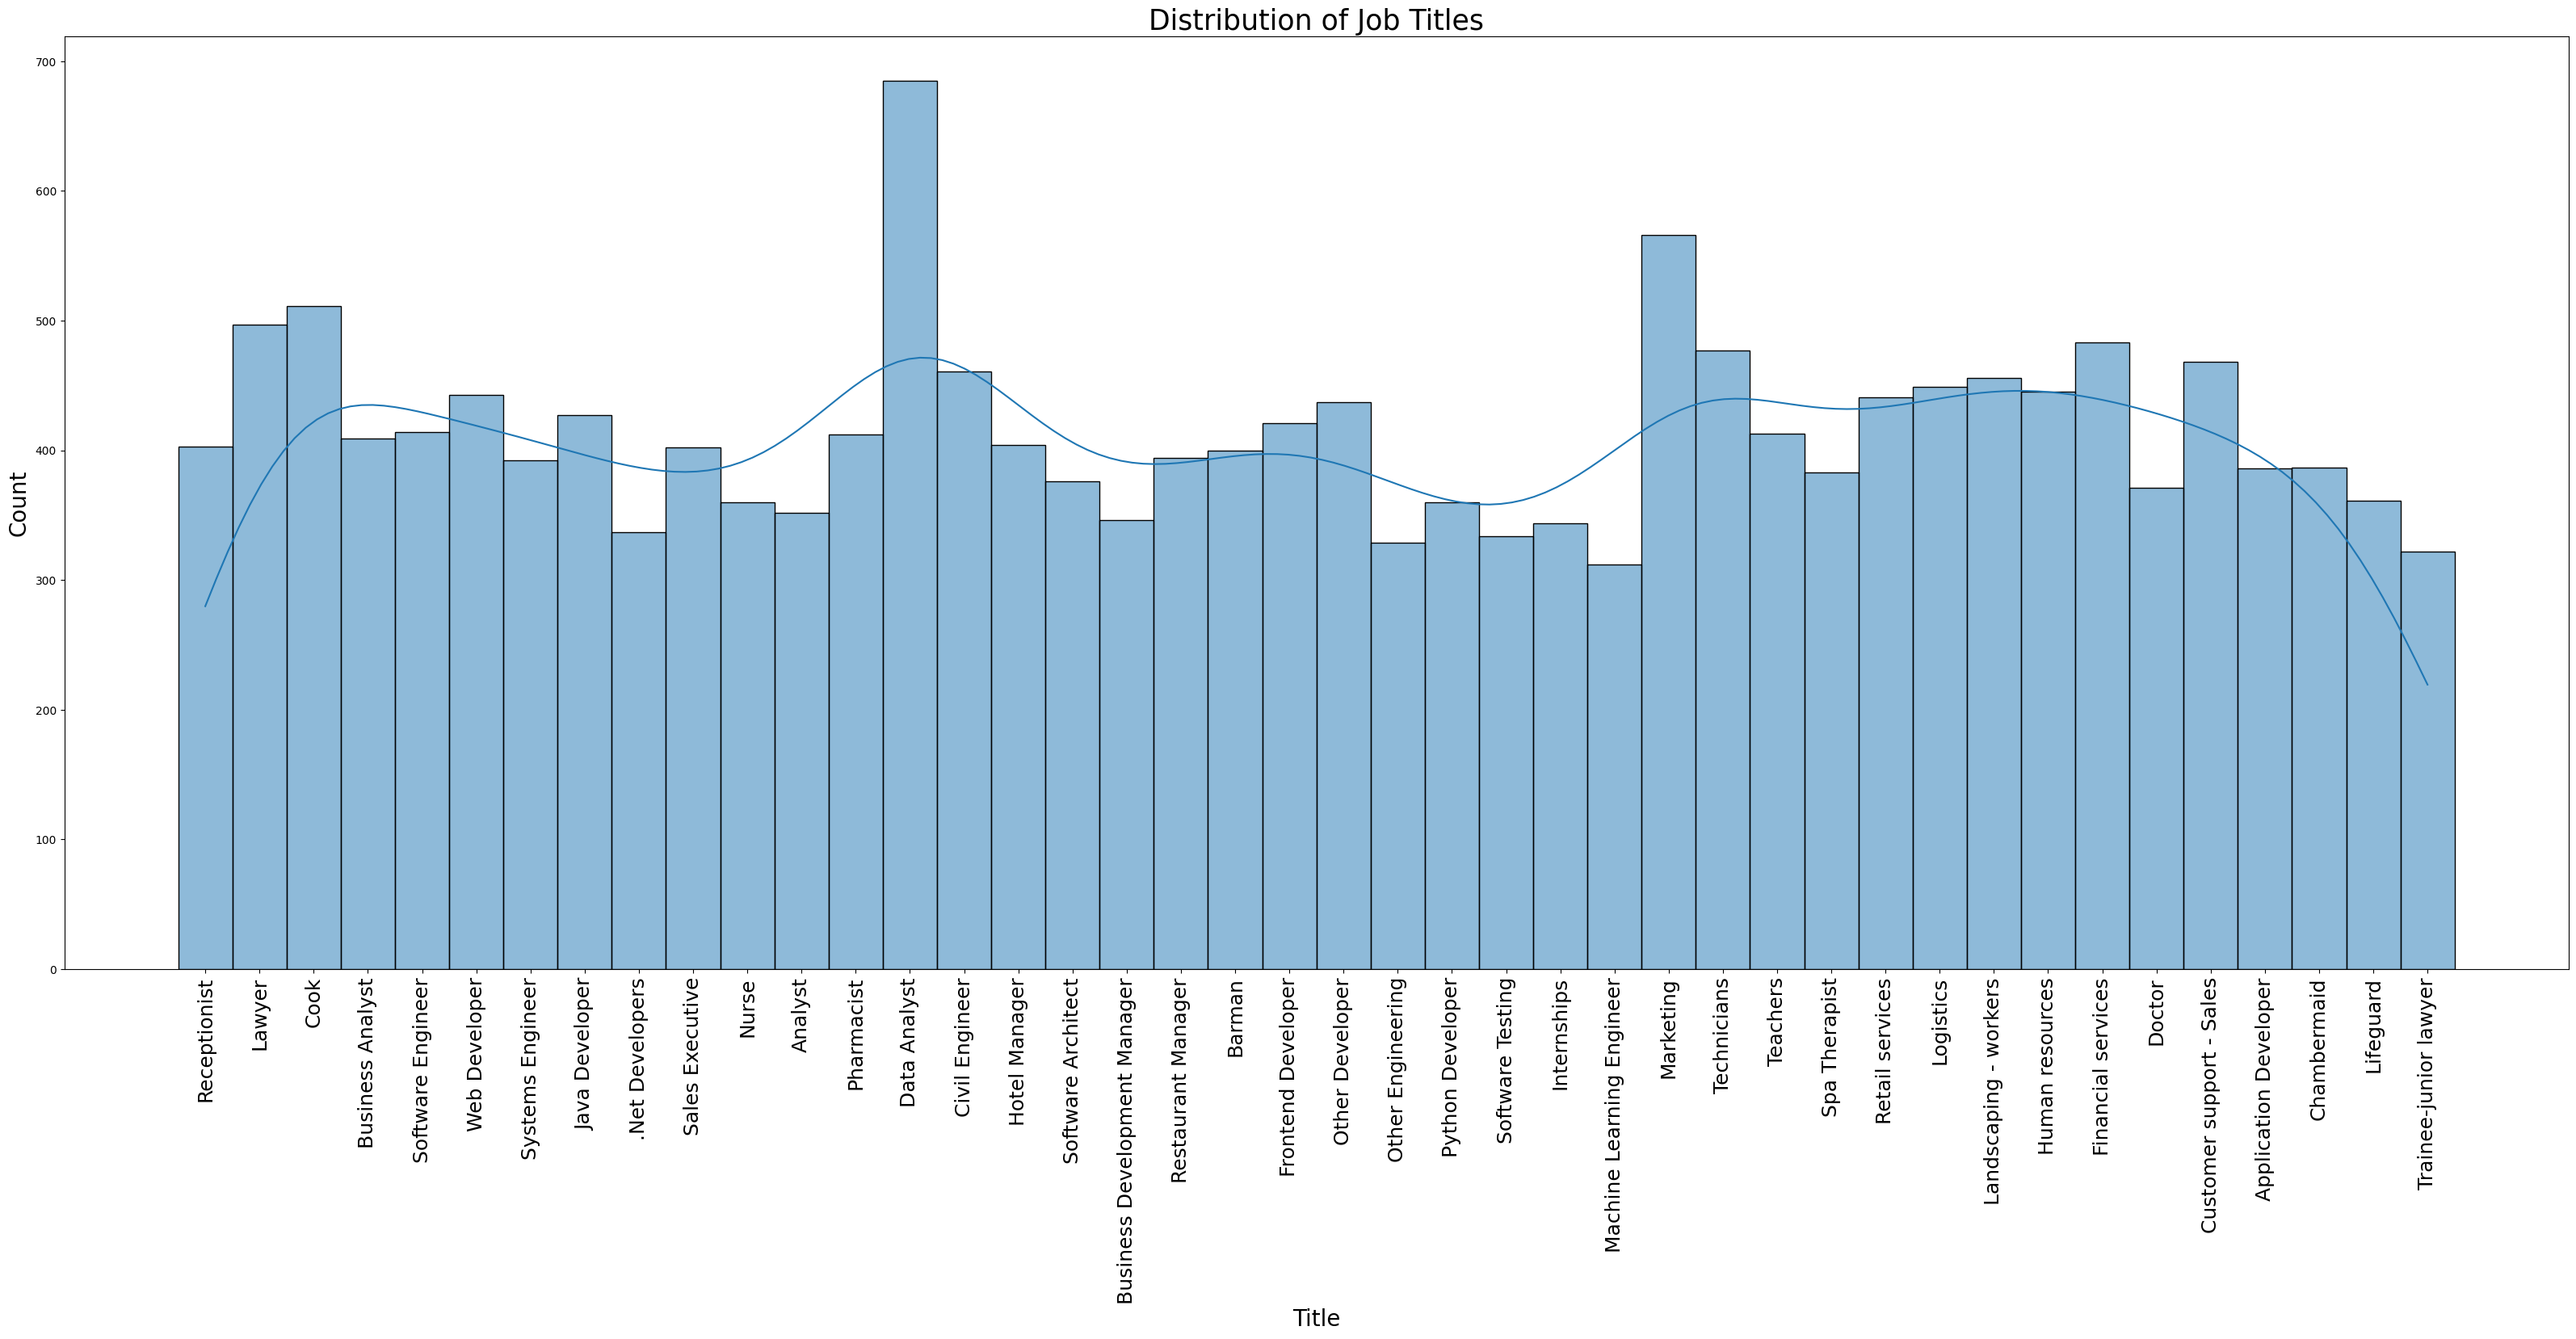

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(40, 15))
sns.histplot(x=df['Title'], kde=True)

# Set larger font size for x-axis labels
plt.xticks(rotation=90, fontsize=18)

# Set larger font size for x and y axis labels
plt.xlabel('Title', fontsize=20)
plt.ylabel('Count', fontsize=20)

# Set larger font size for title
plt.title('Distribution of Job Titles', fontsize=25)

plt.show()

#### Tokenization and Data Preparation

In [4]:
# Initialize the DeBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')

# Label encoding for the 'Title' column
label_encoder = LabelEncoder()
df['Title'] = label_encoder.fit_transform(df['Title'])

# Split the dataset into training, validation, and testing sets (80%, 10%, 10%)
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
test_size = len(df) - train_size - val_size

train_texts, val_texts, test_texts = np.split(df.sample(frac=1, random_state=42), [train_size, train_size + val_size])

# Tokenize the texts
def tokenize_function(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")

train_encodings = tokenize_function(train_texts['Description'])
val_encodings = tokenize_function(val_texts['Description'])
test_encodings = tokenize_function(test_texts['Description'])

train_labels = torch.tensor(train_texts['Title'].values)
val_labels = torch.tensor(val_texts['Title'].values)
test_labels = torch.tensor(test_texts['Title'].values)


C:\Users\AIMVLab\.conda\envs\GPU\lib\site-packages\transformers\convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
C:\Users\AIMVLab\.conda\envs\GPU\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


#### Custom Dataset Class

In [5]:
class JobMatchingDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset = JobMatchingDataset(train_encodings, train_labels)
val_dataset = JobMatchingDataset(val_encodings, val_labels)
test_dataset = JobMatchingDataset(test_encodings, test_labels)


#### Model Initialization

In [6]:
# Initialize the DeBERTa model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained('microsoft/deberta-v3-base', num_labels=df['Title'].nunique())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

#### Training Setup

In [7]:
# Hyperparameters
learning_rate = 5e-5
batch_size = 16
epochs = 4

# Initialize the optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Metric storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


C:\Users\AIMVLab\.conda\envs\GPU\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### Training Loop with Metric Logging

In [8]:
def train(model, train_loader, val_loader, optimizer, scheduler, loss_fn, epochs):
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train_predictions = 0

        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).long()  # Ensure labels are LongTensor

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_train_predictions += (preds == labels).sum().item()

        train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train_predictions / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate(model, val_loader, loss_fn)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}')

def evaluate(model, data_loader, loss_fn):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).long()  # Ensure labels are LongTensor

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct_predictions += (preds == labels).sum().item()

    return total_loss / len(data_loader), correct_predictions / len(data_loader.dataset)



In [9]:
# Start time
start_time = time.time()
# Start training
train(model, train_loader, val_loader, optimizer, scheduler, loss_fn, epochs)
# End time
end_time = time.time()

# Calculate and print the training time
training_time = end_time - start_time
print(f"Training time: {training_time // 60} minutes and {training_time % 60} seconds")

Epoch 1/4 | Train Loss: 1.7380 | Train Accuracy: 0.5076 | Val Loss: 0.5745 | Val Accuracy: 0.8336
Epoch 2/4 | Train Loss: 0.4983 | Train Accuracy: 0.8644 | Val Loss: 0.3516 | Val Accuracy: 0.9039
Epoch 3/4 | Train Loss: 0.2824 | Train Accuracy: 0.9236 | Val Loss: 0.2752 | Val Accuracy: 0.9234
Epoch 4/4 | Train Loss: 0.1769 | Train Accuracy: 0.9547 | Val Loss: 0.2351 | Val Accuracy: 0.9390
Training time: 33.0 minutes and 46.73578119277954 seconds


#### Evaluate on Test Set

In [10]:
# Evaluate on test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loss, test_accuracy = evaluate(model, test_loader, loss_fn)
print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}')


Test Loss: 0.2437 | Test Accuracy: 0.9401


#### Plotting Training and Validation Metrics

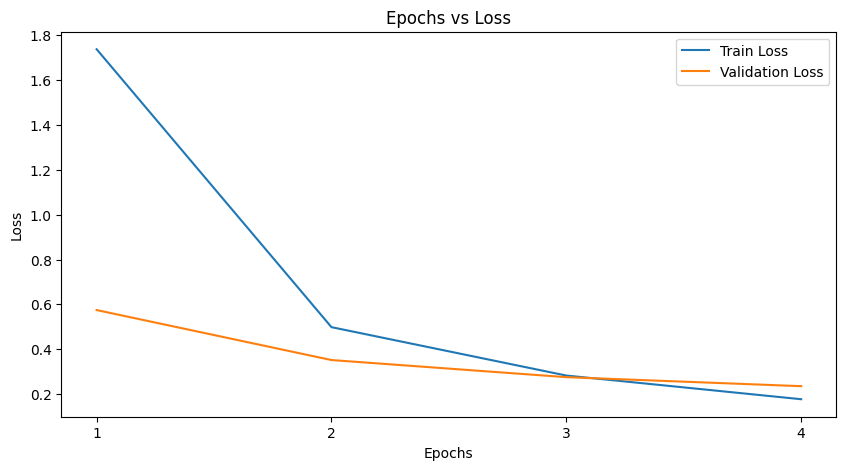

In [11]:
# Plot Loss vs Epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.xticks([1,2,3,4])
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.show()




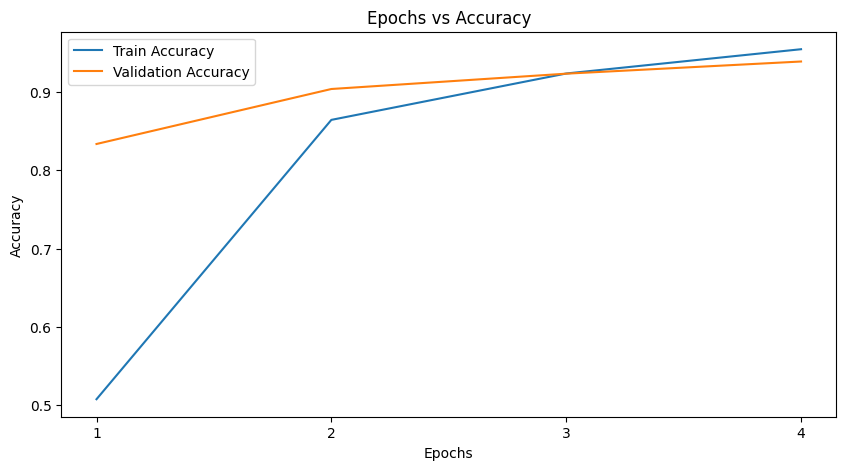

In [12]:
# Plot Accuracy vs Epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.xticks([1,2,3,4])
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy')
plt.legend()
plt.show()

#### Classification Report and Confusion Matrix

In [13]:
# Get predictions for the test set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))



                              precision    recall  f1-score   support

             .Net Developers       1.00      0.91      0.95        34
                     Analyst       0.78      0.83      0.81        35
       Application Developer       0.94      1.00      0.97        34
                      Barman       1.00      1.00      1.00        39
            Business Analyst       0.87      0.84      0.85        49
Business Development Manager       0.88      0.90      0.89        39
                 Chambermaid       1.00      1.00      1.00        36
              Civil Engineer       0.98      1.00      0.99        42
                        Cook       1.00      1.00      1.00        54
    Customer support - Sales       0.94      1.00      0.97        46
                Data Analyst       0.84      0.75      0.80        57
                      Doctor       1.00      1.00      1.00        32
          Financial services       0.98      0.95      0.96        55
          Frontend 

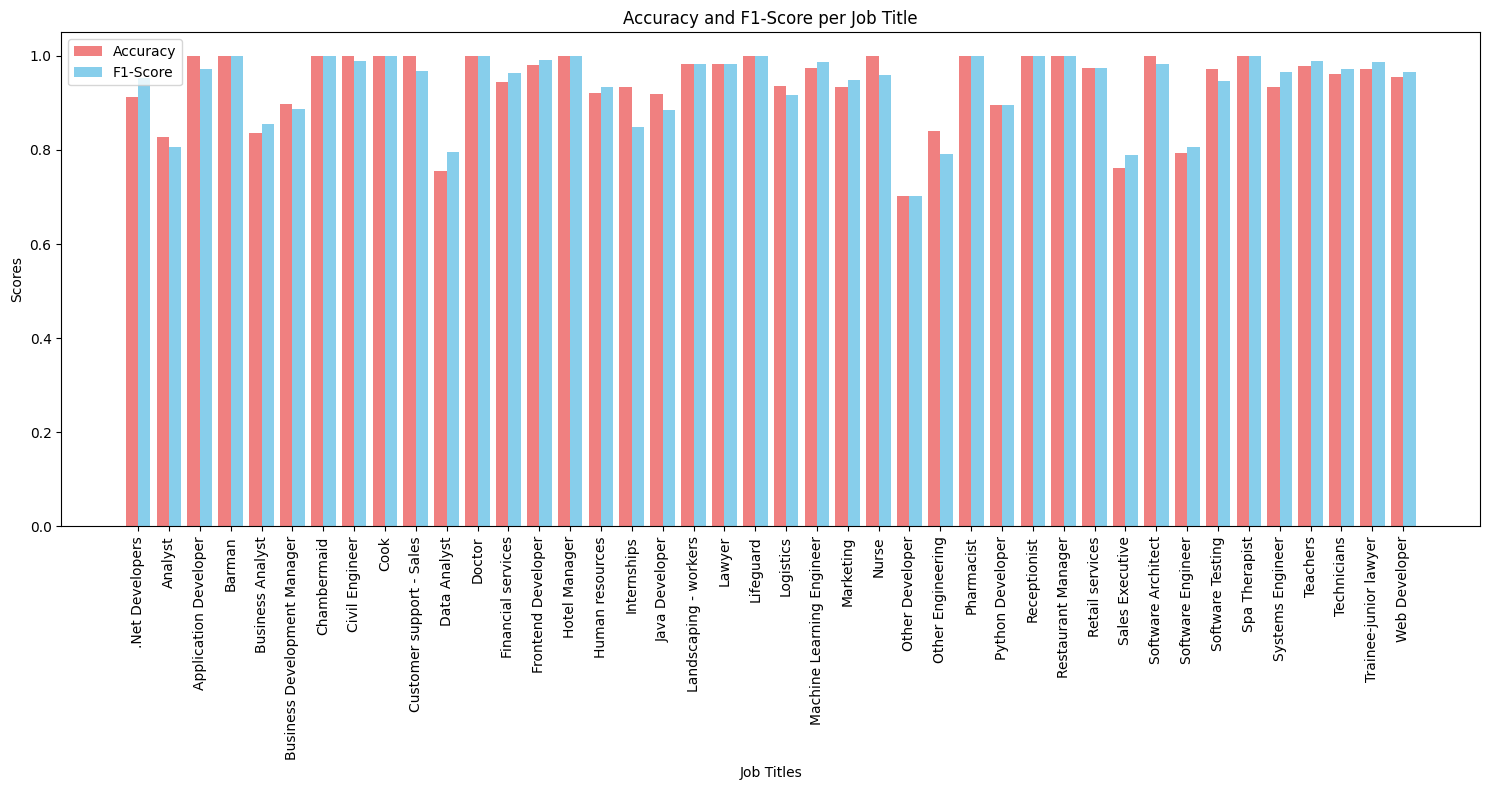

In [14]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np

# Finding the number of unique classes in both true labels
unique_classes = np.unique(all_labels)
# Inversely transforming the unique classes to get their names
class_names = label_encoder.inverse_transform(unique_classes)
# Convert true_labels and predictions to numpy arrays (if they aren't already)
true_labels_np = np.array(all_labels)
predictions_np = np.array(all_preds)

# Get the classification report as a dictionary
report = classification_report(true_labels_np, predictions_np, labels=unique_classes, target_names=class_names, output_dict=True)

# Extract the F1-scores for each class
f1_scores = [report[title]['f1-score'] for title in label_encoder.classes_]

# Calculate the accuracy per class
accuracy_per_class = []
for i, title in enumerate(label_encoder.classes_):
    # Mask to filter only the samples that belong to class i
    class_mask = (true_labels_np == i)
    
    # Calculate accuracy for class i
    class_accuracy = accuracy_score(true_labels_np[class_mask], predictions_np[class_mask])
    accuracy_per_class.append(class_accuracy)

# Plotting the F1-scores and Accuracy for each class_
plt.figure(figsize=(15, 8))
x = np.arange(len(label_encoder.classes_))

# Plot accuracy and F1-score with gentle colors
plt.bar(x - 0.2, accuracy_per_class, 0.4, label='Accuracy', color='#F08080')  # Peach
plt.bar(x + 0.2, f1_scores, 0.4, label='F1-Score', color='#87CEEB')  # Lavender

# Customize the plot
plt.xticks(x, label_encoder.classes_, rotation=90)
plt.xlabel('Job Titles')
plt.ylabel('Scores')
plt.title('Accuracy and F1-Score per Job Title')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


In [16]:


# Assuming 'le' is the LabelEncoder and 'y_test', 'y_pred_linear' are already defined
report = classification_report(true_labels_np,predictions_np, target_names=label_encoder.classes_, output_dict=True)

# Extract the F1-score and accuracy per class (excluding 'accuracy' key which is overall)
f1_scores = [round(report[title]['f1-score'], 2) for title in label_encoder.classes_]
accuracy_per_class = []

for i, title in enumerate(label_encoder.classes_):
    class_mask = (true_labels_np == i)
    class_accuracy = round(accuracy_score(true_labels_np[class_mask], predictions_np[class_mask]), 2)
    accuracy_per_class.append(class_accuracy)

# Create a DataFrame for better visualization and saving
scores_df = pd.DataFrame({
    'Job Title': label_encoder.classes_,
    'Accuracy': accuracy_per_class,
    'F1-Score': f1_scores
})

# Save the DataFrame to CSV
csv_file_path = 'accuracy_f1_scores_job_titles_DeBERTa.csv'
scores_df.to_csv(csv_file_path, index=False)

# Optionally print the path to the saved file
print(f"Data saved to {csv_file_path}")


Data saved to accuracy_f1_scores_job_titles_DeBERTa.csv


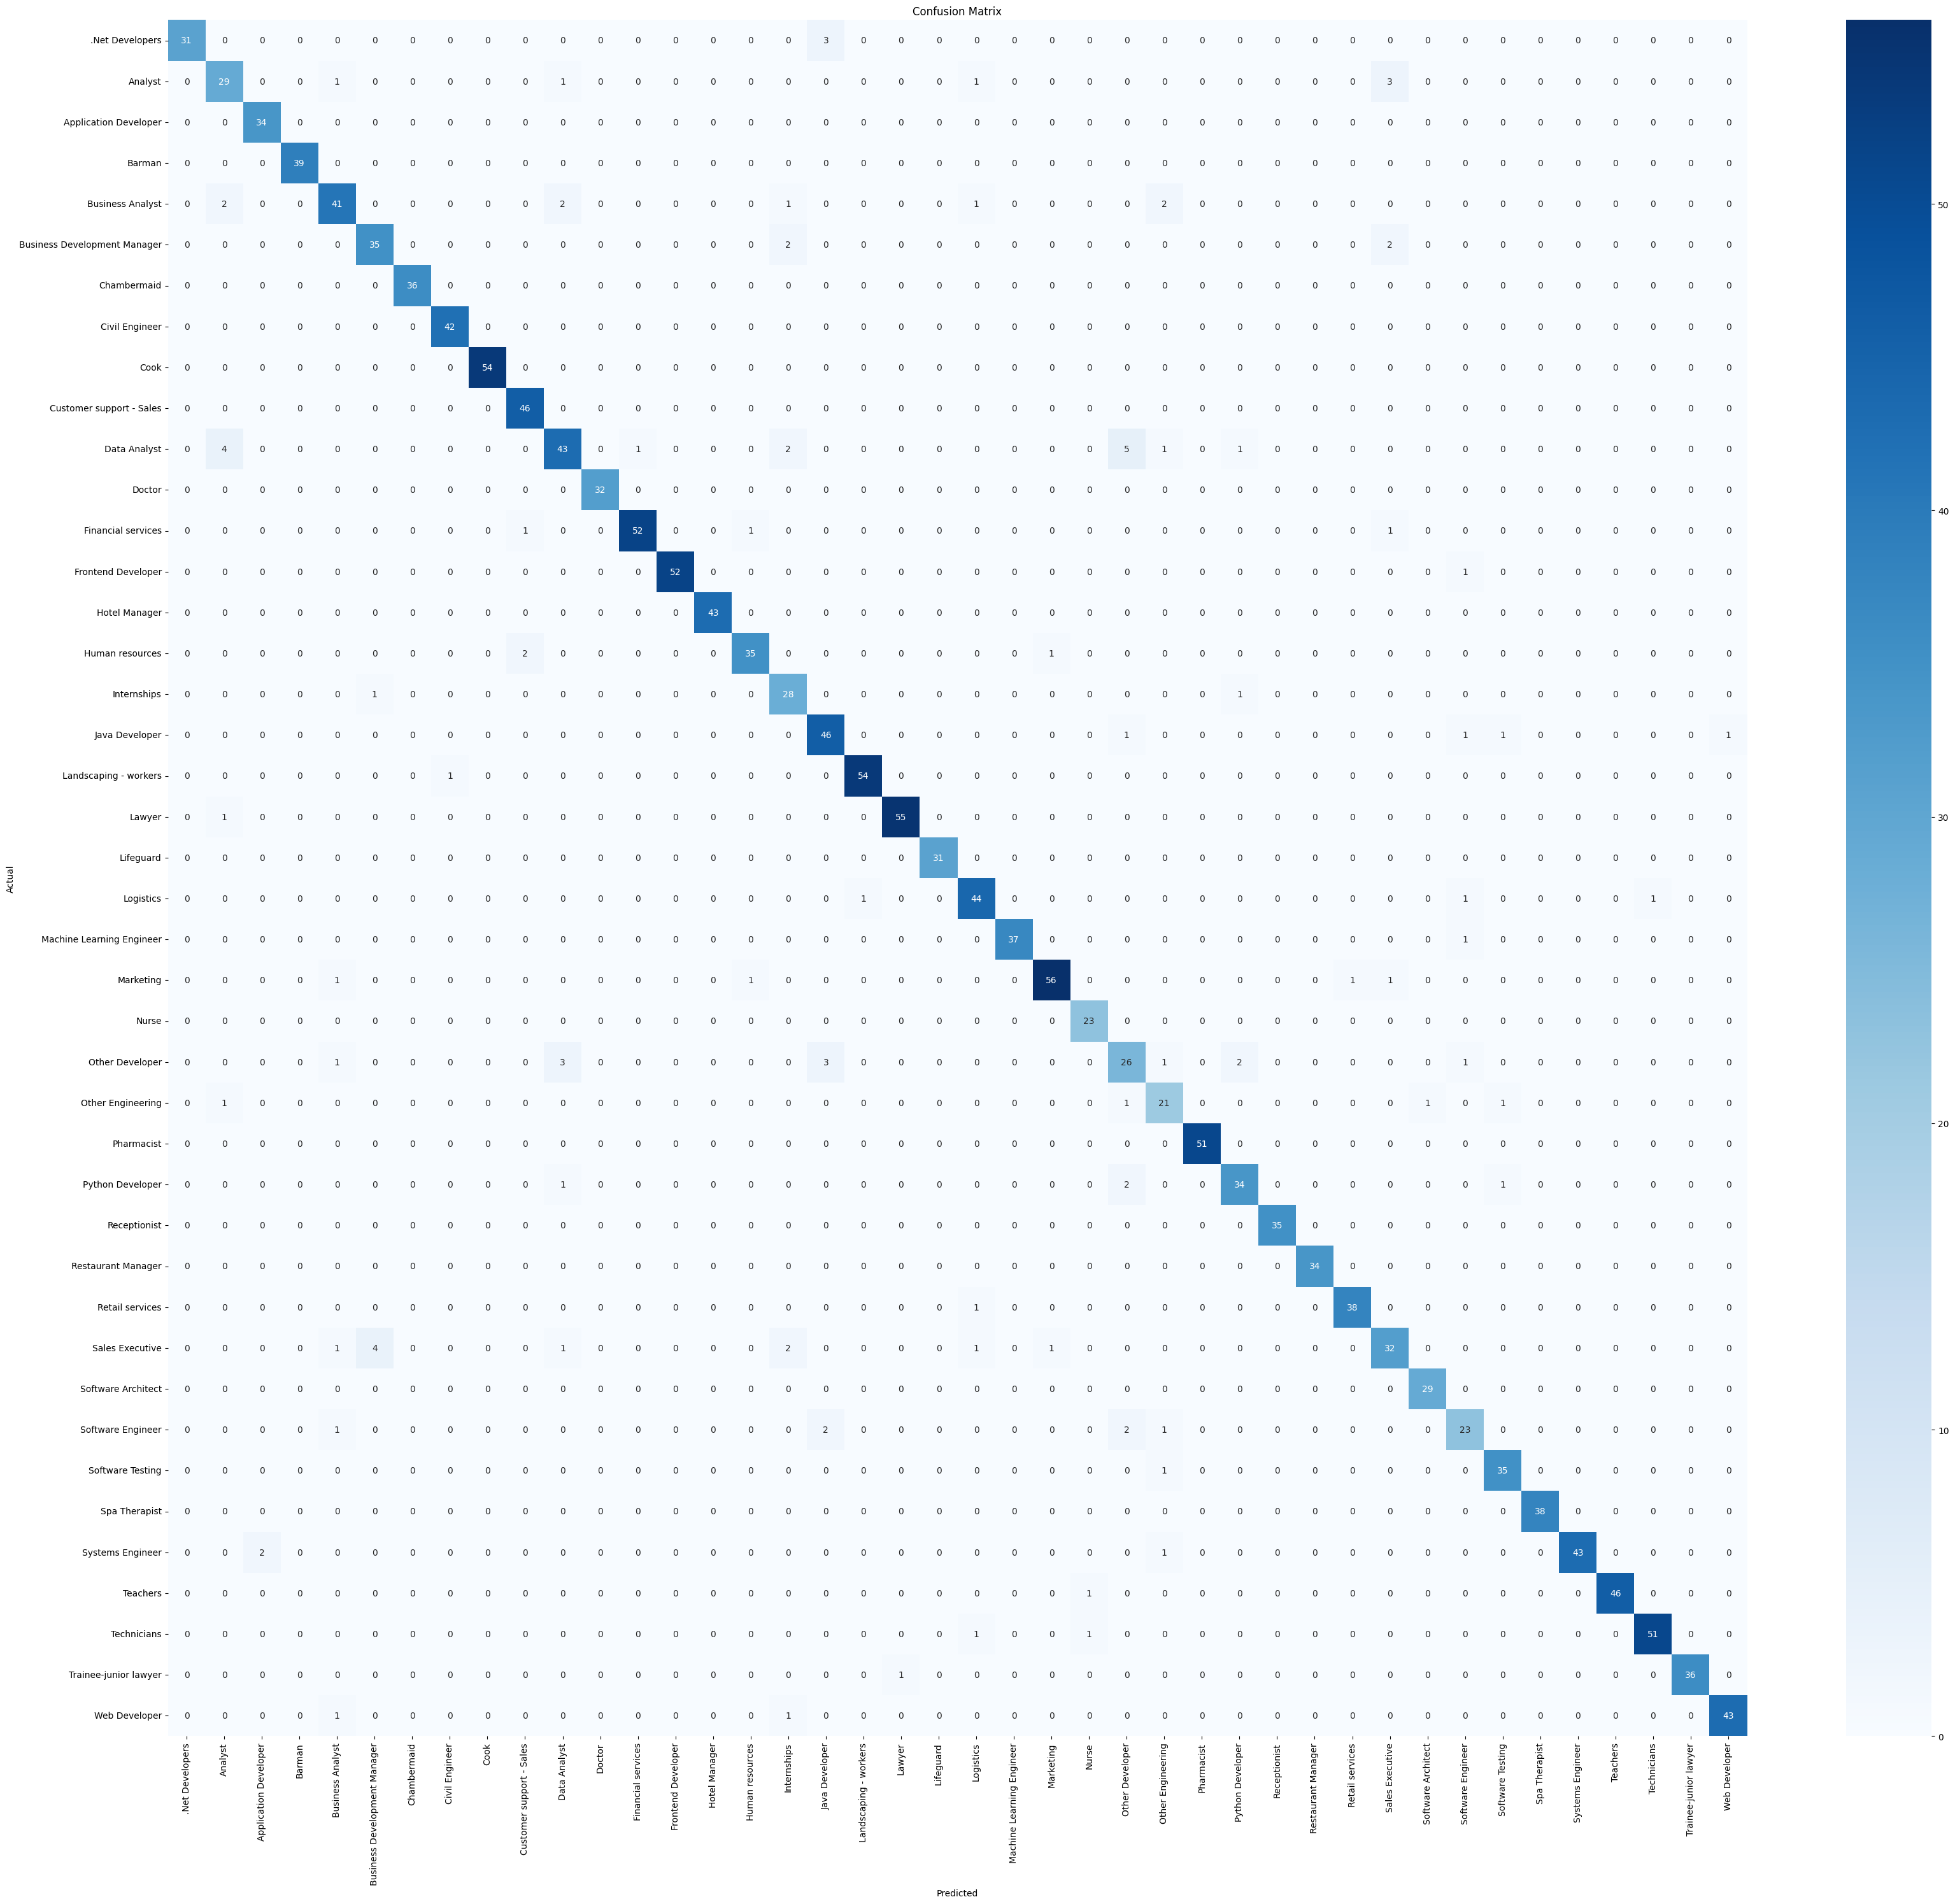

In [17]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(40, 35))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [18]:
# Save the model
model_save_path = 'deberta_model.pth'
torch.save(model.state_dict(), model_save_path)

# Save the tokenizer
tokenizer_save_path = 'deberta_tokenizer'
tokenizer.save_pretrained(tokenizer_save_path)


('deberta_tokenizer\\tokenizer_config.json',
 'deberta_tokenizer\\special_tokens_map.json',
 'deberta_tokenizer\\spm.model',
 'deberta_tokenizer\\added_tokens.json',
 'deberta_tokenizer\\tokenizer.json')

In [19]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_path)

# Load the model
model = AutoModelForSequenceClassification.from_pretrained('microsoft/deberta-v3-base', num_labels=df['Title'].nunique())
model.load_state_dict(torch.load(model_save_path))
model.to(device)
model.eval()  # Set the model to evaluation mode


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

In [20]:
def predict_title(description, model, tokenizer, label_encoder):
    # Tokenize the input description
    inputs = tokenizer(description, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1)

    # Convert prediction to the corresponding label
    predicted_title = label_encoder.inverse_transform(preds.cpu().numpy())
    return predicted_title[0]

# Example prediction
description = "We are looking for a highly motivated individual with strong communication skills to join our team as a receptionist."
predicted_title = predict_title(description, model, tokenizer, label_encoder)
print(f"Predicted Title: {predicted_title}")


Predicted Title: Receptionist


In [21]:
def predict_titles(descriptions, model, tokenizer, label_encoder):
    # Tokenize the input descriptions
    inputs = tokenizer(descriptions, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Make predictions
    with torch.no_grad():
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1)

    # Convert predictions to the corresponding labels
    predicted_titles = label_encoder.inverse_transform(preds.cpu().numpy())
    return predicted_titles

# Example batch prediction
descriptions = [
    "We are looking for a highly motivated individual with strong communication skills to join our team as a receptionist.",
    "A leading financial institution is seeking an experienced lawyer to join their legal team."
]
predicted_titles = predict_titles(descriptions, model, tokenizer, label_encoder)
print(f"Predicted Titles: {predicted_titles}")


Predicted Titles: ['Receptionist' 'Lawyer']
